# Equation
# $$ \dot{v} (t)= g$$

## Initial condition:
# $$v(0) = 0$$

# Solutions
# $$v(t) = gt t$$
# $$u(t) = \mbox{Real}z(t) = \cos t$$
# $$v(t) = \mbox{Im}z(t)   = \sin t$$

In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import time
import tensorflow_probability as tfp
from tqdm.notebook import tnrange
import seaborn as sns


2023-01-12 09:49:59.054994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 09:49:59.141084: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-12 09:49:59.162207: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 09:49:59.574111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
tf.__version__
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

In [ ]:
class MyDense(tf.keras.layers.Layer):
    '''
    Inputs:
    
    units : number of neurons
    initialization = 0,1
           if activations are:
           init =0(He): ReLU, Leaky ReLU, ELU, GELU, Swish, Mish
           init =1(Xavier_Glorot): None, tanh, sigmoid, softmax 
           
    activation: activation to be use either string or callable
    
    
    Output:
            returns activation(wx+b) with appropriate initialization
    
    '''
    def __init__(self, units = 20, initialization=None, activation = None): #None = gives basic activation
        super(MyDense, self).__init__()
        self.units = units   
        self.init = initialization
        
        if activation == 'mish':
            self.activation = tf.keras.activations.get(self.mish_activation)
        else:
            self.activation = tf.keras.activations.get(activation)
       
    @tf.function
    def mish_activation(self, x):
#         print(f'called_mish')
    #     mish(x) = xtanh(softsplus(x))  it needs  He initialization
        return x*tf.math.tanh(tf.nn.softplus(x))       
    
    
# We get them from the shape of w= shape
# shape[0] : number of inputs to the neuron
# shape[1] : number of output from the neuron
#     @tf.function(reduce_retracing=True)
    def Xavier_Glorot_initializer(self,shape, dtype=tf.float32):
        '''
        Xavier Glorot: initialization must be used for the following activations:
        None, tanh, sigmoid, softmax

       input: 
            shape = [number of columns, units]

       output:
               samples normal distribution of mean = 0 stddev = sqrt(2./inputs_shape+units)
        '''
#         print('Initial weight with  Xavier Glorot ')
        
        shape_to_float = tf.cast(shape, dtype=tf.float32)
        fanin = shape_to_float[0]
        fanout = shape_to_float[1]
        stddev = tf.sqrt(2. /(fanin+fanout)  )
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)
    
#     @tf.function(reduce_retracing=True) 
    def He_initializer(self,shape,dtype = tf.float32):
        '''
        input: 
                shape = [number of columns, units]

        He (aka He normal)initialization must be used for the following activations:
        ReLU, Leaky ReLU, ELU, GELU, Swish, Mish

        He initialization:
        random normal with variance and mean of 2/fanin = 2/no. of inputs = 2/inputs
        '''
        shape_to_float = tf.cast(shape, dtype=tf.float32)
#         print(f'INIT shape = {shape}, dtype = {shape.dtype}')
#         fanin = tf.constant(shape[0], dtype = tf.float32)
        fanin = shape_to_float[0]
#         print(f'fanin = {fanin}')
        stddev = tf.sqrt(2. /fanin)
#         print(f'stddev = {stddev}')
#         print('Initial weight with  He')
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)        

#     Initialize kernel aka w
    def init_w(self, input_shape):
        shape = [input_shape[-1], self.units]
        shape = tf.constant(shape, dtype=tf.int32)

        if self.init == 0:
#             Initialize with He : Relu and variants activation functions
            value = self.He_initializer(shape)
        else:
#             Initialize with Xavier_Glorot : None, tanh, sigmoid, softmax activation functions
            value = self.Xavier_Glorot_initializer(shape)
            
        return tf.Variable(name = 'kernel', initial_value=value ,trainable = True )

#     Initialize biase aka b
    def init_b(self):
#         value = tf.zeros(self.units)  # originsl
        value = tf.ones(self.units)
        return tf.Variable(name = 'bias', initial_value=value ,trainable = True )    
       
        
    def build(self, input_shape):
        self.w = self.init_w(input_shape)
        self.b = self.init_b()
        
    def call(self, inputs):
        out_put = self.activation(tf.matmul(inputs, self.w) + self.b)
        return out_put
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "weight": self.w,
            "biase": self.b,
            })
        return config

In [1]:
class Z_approx(tf.keras.Model):
    def __init__(self,v0,num_of_hid_layers = None, units_per_layer = None, num_out=1, initialization=None, activation=None):
        super(Z_approx,self).__init__()
        self.num_of_hid_layers = num_of_hid_layers
        self.units_per_layer = units_per_layer
        self.num_out = num_out
        self.init = initialization
        self.normalize = tf.keras.layers.Normalization()
        self.real_init =v0[0] 
        self.imag_init =v0[1] 

        if self.init == 0:
            kerner_init = tf.keras.initializers.he_normal()
        else:
            kerner_init = tf.keras.initializers.glorot_normal()
            
        
        
        
        self.initialization = initialization
        self.activation = activation
        
        
        
        self.hidden_layers = [MyDense(self.units_per_layer, self.initialization, self.activation) 
                              for _ in range(self.num_of_hid_layers)]
        
        self.out = MyDense(units=self.num_out, initialization=self.initialization)
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(self.num_of_hid_layers)]
    
    def call(self, inputs):
        '''
        Add BN before since the layer includes activations
        
        '''
        for i in range(self.num_of_hid_layers):
            if i == 0:
                x = self.normalize(inputs)
                x = self.bn[i](x)
            else:
                x = self.bn[i](x)
                
            x = self.hidden_layers[i](x)
        return self.out(x)     
    
    def pinn_net(self,t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)         
            z_real = self.call(t)[:,0:1]
            z_imag = self.call(t)[:,1:2]
        dz_realdt = tf.cast(tape.gradient(z_real,t),dtype=tf.float32)
        dz_imagdt = tf.cast(tape.gradient(z_imag,t),dtype=tf.float32)  
        del tape
        
        
#         Residual pde        
#     derivatives must be dtype tf.float32
#     dzdt = iz(t)
        dzdt = tf.complex(dz_realdt,dz_imagdt) # dzdt = dudt + idvdt . 
        z = tf.complex(z_real,z_imag)
        rhs = z*1.j

    #     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper

        residual_real = tf.math.real(dzdt) - tf.math.real(rhs) # = real(LHS)-Real(RHS)
        residual_imag = -tf.math.imag(dzdt) + tf.math.imag(rhs) # = -Imag(LHS)+Img(RHS)
        

        #         Initial conditions
#         residual ics
        real0,imag0 = self.call(t[0]*tf.ones_like(t))[:,:1],self.call(t[0]*tf.ones_like(t))[:,1:]
#        
        residue_ic_real = real0  -  self.real_init
        residue_ic_imag = imag0  -  self.imag_init
        

        return residual_real,residual_imag, residue_ic_real,residue_ic_imag
        
        
    @tf.function    
    def loss(self,t):
        residual_real,residual_imag, residue_ic_real,residue_ic_imag = self.pinn_net(t)
        
        loss_real  = tf.reduce_mean(tf.square(residual_real))
        loss_imag  = tf.reduce_mean(tf.square(residual_imag))
        loss_real_ic = tf.reduce_mean(tf.square(residue_ic_real))
        loss_imag_ic = tf.reduce_mean(tf.square(residue_ic_imag))
        
        return loss_real,loss_real_ic,loss_imag,loss_imag_ic
    
    
    def get_config(self):
        weights_l = []
        biases_l = []
        config = super().get_config()
        config.update({
            "weight": self.w,
            "biase": self.b,
            })
        
        return config
    
def calc_imbalance(t):
    with tf.GradientTape(persistent=True) as tape:
        loss_real,loss_real_ic,loss_imag,loss_imag_ic = z_hat.loss(t)
        
    dresidue_pde_real = tape.gradient(loss_real,z_hat.trainable_variables)  
    dresidue_ic_real  = tape.gradient(loss_real_ic,z_hat.trainable_variables)
    
    dresidue_pde_imag = tape.gradient(loss_imag,z_hat.trainable_variables)  
    dresidue_ic_imag = tape.gradient(loss_imag_ic,z_hat.trainable_variables)
    
    del tape
    return loss_real,loss_real_ic,dresidue_pde_real,dresidue_ic_real, loss_imag,loss_imag_ic,dresidue_pde_imag,dresidue_ic_imag    

NameError: name 'tf' is not defined

In [39]:
t = tf.cast(tf.linspace(0,1,50)[:,tf.newaxis],tf.float32)
real_int = tf.constant(1.0, dtype = tf.float32)
imag_int = tf.constant(0.0, dtype = tf.float32)
z_init = tf.constant(np.array([real_int,imag_int]),tf.float32)
# #initiazing
z_hat = Z_approx(z_init,num_of_hid_layers = 3, units_per_layer = 30, num_out=2, initialization = 1,activation = tf.nn.tanh)
z_hat.build(t.shape)
optim = tf.keras.optimizers.Adam()
# real0,imag0 = z_hat(t[0]*tf.ones_like(t))[:,:1],z_hat(t[0]*tf.ones_like(t))[:,1:]

In [45]:
@tf.function
def train_update_jun(t):
    S = len(tf.shape_n(z_hat.trainable_variables))
    lamda1_real = 1.
    lamda1_imag = 1.
    
    alpha = .9

    num_per_layer_real = []
    den_per_layer_real = []
    
    num_per_layer_imag = []
    den_per_layer_imag = []  
    
    with tf.GradientTape() as tape:
        loss_real,loss_real_ic,dresidue_pde_real,dresidue_ic_real, loss_imag,loss_imag_ic,dresidue_pde_imag,dresidue_ic_imag = calc_imbalance(t)
#         print(f'loss pde :{residue_pde} loss ic :{residue_ic}')
#         print(f'combined loss {residue_pde + residue_ic }')
        for i in range(S):
        
            lamda1_real = 1.
            lamda1_imag = 1.
            
            num_real = tf.reduce_max(tf.abs(dresidue_pde_real[i]))
            den_real = tf.reduce_mean(tf.abs(dresidue_ic_real[i]))
            
            num_imag = tf.reduce_max(tf.abs(dresidue_pde_imag[i]))
            den_imag = tf.reduce_mean(tf.abs(dresidue_ic_imag[i]))
            

            if (den_imag == 0) or (den_real == 0.0):
#                 print(f'den_imag = {den_imag}')
#                 print(f'den_real = {den_real}')
#                 den = 1e-10
                
            num_per_layer_real.append(num_real)
            den_per_layer_real.append(den_real)
            
            num_per_layer_imag.append(num_imag)
            den_per_layer_imag.append(den_imag)

        num_final_real =  tf.reduce_max( tf.stack(num_per_layer_real))    #stack flattens list
        den_final_real = tf.reduce_mean(tf.stack(den_per_layer_real))
        
        num_final_imag =  tf.reduce_max( tf.stack(num_per_layer_imag))    #stack flattens list
        den_final_imag = tf.reduce_mean(tf.stack(den_per_layer_imag))        

        lambda_hat_real = num_final_real/den_final_real
        lambda_hat_imag = num_final_imag/den_final_imag

        lamda1_real = (1.-alpha)*lamda1_real + alpha*lambda_hat_real
        lamda1_imag = (1.-alpha)*lamda1_imag + alpha*lambda_hat_imag

#         print(f'lambda for layer {i} is {lamda1}')
#         print(f'loss pde :{residue_pde} loss ic :{residue_ic}')
#         print(f'loss pde :{residue_pde} loss balcanced :{lamda1*residue_ic}')


        new_loss_real = loss_real + lamda1_real*loss_real_ic
#         print(f'Real loss :{new_loss_real}')
        new_loss_imag = loss_imag + lamda1_imag*loss_imag_ic
#         print(f'Imag loss :{new_loss_imag}')
        new_loss = new_loss_real + new_loss_imag
#         print(f'final loss before :{new_loss}')
    dddd = tape.gradient(new_loss, z_hat.trainable_variables)    
    optim.apply_gradients(zip(dddd, z_hat.trainable_variables))
    return new_loss

In [46]:
1<2 or 2>3

True

In [47]:
start = time.time()
losses = []
loss_decrease = []
best_so_far = np.inf
losses.append(train_update_jun(t))

for epoch in range(50000):
    loss = train_update_jun(t)
    if loss < losses[-1]:
        if loss < best_so_far:
            best_so_far = loss
            loss_decrease.append(loss)
#                 print(f'******************best so far is updated to :{best_so_far}********************')
            z_hat.save_weights('best_model')
             

    if np.isnan(loss):
        print(f'Loss :{loss}')
        break

    losses.append(loss)

    if epoch%1000==0:
        print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
        print(end = ".")

z_hat.load_weights('best_model')

den_imag = Tensor("Mean_1:0", shape=(), dtype=float32)
den_real = Tensor("Mean:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_3:0", shape=(), dtype=float32)
den_real = Tensor("Mean_2:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_5:0", shape=(), dtype=float32)
den_real = Tensor("Mean_4:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_7:0", shape=(), dtype=float32)
den_real = Tensor("Mean_6:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_9:0", shape=(), dtype=float32)
den_real = Tensor("Mean_8:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_11:0", shape=(), dtype=float32)
den_real = Tensor("Mean_10:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_13:0", shape=(), dtype=float32)
den_real = Tensor("Mean_12:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_15:0", shape=(), dtype=float32)
den_real = Tensor("Mean_14:0", shape=(), dtype=float32)
den_imag = Tensor("Mean_17:0", shape=(), dtype=float32)
den_real = Tensor("Mean_16:0", shape=(), dtype=float32)
den_

In [48]:
z_hat.loss(t)

(<tf.Tensor: shape=(), dtype=float32, numpy=6.20706e-07>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.5765078e-07>,
 <tf.Tensor: shape=(), dtype=float32, numpy=7.223204e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.1338132e-08>)

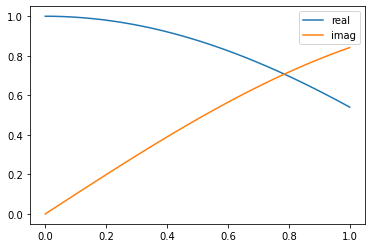

In [49]:
# True solutions
x_true = lambda t : tf.math.cos(t)
y_true = lambda t : tf.math.sin(t)

plt.plot(t, x_true(t) ,label = 'real')
plt.plot(t,  y_true(t), label = 'imag')
plt.legend()

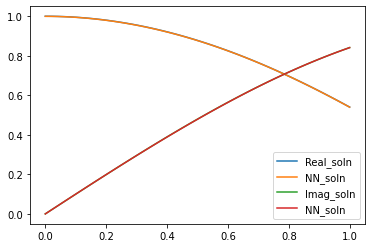

In [50]:
plt.plot(t, x_true(t) ,label = 'Real_soln')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN_soln')
plt.legend()

plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [20]:
def mix_optimizers():
    shapes = tf.shape_n(z_hat.trainable_variables)
    length_shapes = len(shapes)
    count = 0
    idx = []
    part = []

#     loss_pde,loss_ic = train_update_jun(t)
    total_loss = train_update_jun(t)
    print(f'Initial loss : {total_loss}')


    for i in range(length_shapes):
        n = np.product(shapes[i])
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
        count += n   
        part.extend([i]*n)

    def update_weights(OneD):
        params = tf.dynamic_partition(OneD, part, length_shapes)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            z_hat.trainable_variables[i].assign(tf.reshape(param, shape))

    def flatten_the_parameters(weights):
        return tf.dynamic_stitch(idx, weights) 

#     @tf.function
    def value_and_gradient(flat_weights):
        #update weights 
        update_weights(flat_weights)
        with tf.GradientTape() as g:
            los = train_update_jun(t)
        grad = g.gradient(los, z_hat.trainable_variables) 
        flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
        return los, flattend_grad  


    start_time2 = time.time()

    flat_parameters = flatten_the_parameters(z_hat.trainable_variables)
    start = tf.constant(flat_parameters)  # Starting point for the search.
    grads_lists = []
    optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
    
    if optim_results.
    grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
    grads_lists.append(grad_curr)
    
#     if optim_results.converged.numpy() == True:
#         break

    while  optim_results.converged.numpy() == False:
        optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, max_iterations=5000)
        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        print('')
        new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

        if new_grad == grads_lists[-1]:
            print('NO change')
            loss = train_update_jun(t)
            if loss < 1e-6:
                print('satiesfied')
                break
            else:
                mix_optimizers()
                



    print('converged:', optim_results.converged.numpy())
    print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
    print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
    update_weights(optim_results.position)

    loss_pde,loss_ic = z_hat.loss(t)
    los = loss_pde + loss_ic
    print('loss',los)
    print('Times : ',time.time()-start_time2,'\n')     

In [ ]:
S = length_shapes
lamda1 = 1.

num_per_layer = []
den_per_layer = []
with tf.GradientTape() as tape:
    residue_pde, residue_ic,dresidue_pde,dresidue_ic   = calc_imbalance(t)
    print(f'loss pde :{residue_pde} loss ic :{residue_ic}')
    print(f'combined loss {residue_pde + residue_ic }')
    for i in range(S):
        lamda1 = 1.
        num = tf.reduce_max(tf.abs(tf.reshape(dresidue_pde[i],(-1))))
        den = tf.reduce_mean(tf.abs(tf.reshape(dresidue_ic[i],(-1))))

        num_per_layer.append(num)
        den_per_layer.append(den)

    num_final =  tf.reduce_max( tf.stack(num_per_layer))    #stack flattens list
    den_final = tf.reduce_mean(tf.stack(den_per_layer))

    lambda_hat = num_final/den_final

    lamda1 = (1.-alpha)*lamda1 + alpha*lambda_hat

    print(f'lambda for layer {i} is {lamda1}')
    print(f'loss pde :{residue_pde} loss ic :{residue_ic}')
    print(f'loss pde :{residue_pde} loss balcanced :{lamda1*residue_ic}')
    

    new_loss = residue_pde + lamda1*residue_ic
    print(f'final loss before :{new_loss}')
dddd = tape.gradient(new_loss, z_hat.trainable_variables)    
optim.apply_gradients(zip(dddd, z_hat.trainable_variables))

residue_pde, residue_ic,dresidue_pde,dresidue_ic   = calc_imbalance(t)
new_loss = residue_pde + lamda1*residue_ic
new_loss = residue_pde + lamda1*residue_ic
print(f'final loss after update :{new_loss}')
#     plt.title('Gradients for parameter '+str(i))
#     plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='pde_res'+str(i) )
#     plt.plot(tf.reshape(dresidue_ic[i],(-1)),label ='ics_res'+str(i))
#     plt.legend()
#     plt.show()
    
#     plt.title('modified Gradients for parameter '+str(i))
#     plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='mod_pde_res'+str(i) )
#     plt.plot(tf.reshape(lamda1*dresidue_ic[i],(-1)),label ='mod_ics_res'+str(i))
#     plt.legend()
#     plt.show()
    
    
    
    
    
    
#             if tf.size(grad_residual_x[n].shape) == 2 and grad_residual_x[n].shape[0] == 1:
#                 plt.plot(grad_residual_x[n][0],label = 'grad_res')
#                 plt.plot(grad_mse_x0_real[n][0],label = 'grad_IC')
#                 plt.title('layer_corrected = '+str(n))
#                 plt.legend()
#                 plt.show()


#             print(f'shapes:{grad_residual_x[n].shape} \n reduce_prod :{tf.reduce_prod(grad_residual_x[n].shape)}')
#     max_grad_res_list_real.append( tf.reduce_max(tf.math.abs(grad_residual_x[n])))
#     max_grad_res_list_imag.append( tf.reduce_max(tf.math.abs(grad_residual_y[n])))

#     max_grad_res_list_real_bc.append( tf.reduce_mean(tf.math.abs(grad_mse_x0_real[n])))
#     max_grad_res_list_imag_bc.append( tf.reduce_mean(tf.math.abs(grad_mse_y0_imag[n])) )

# lambda_residue_hat_real = tf.reduce_max(max_grad_res_list_real) / tf.reduce_mean(max_grad_res_list_real_bc)
# lambda_residue_hat_imag = tf.reduce_max(max_grad_res_list_imag) / tf.reduce_mean(max_grad_res_list_imag_bc)

# lambda_real = (1. - alpha)*lambda_real + alpha*lambda_residue_hat_real
# lambda_imag = (1. - alpha)*lambda_imag + alpha*lambda_residue_hat_imag 

# total_loss_updated = residual_x + mse_x0_real*lambda_real  + residual_y + mse_y0_imag*lambda_imag
# #         print(f'loss residue_real :{residual_x} ,loss residue_imag :{residual_y}' )
# #         print('Old loss_bc')
# #         print(f'loss residue_real_bc :{mse_x0_real} ,loss residue_imag_bc :{mse_y0_imag}' )
# #         print('New loss_bc')
# #         print(f'loss residue_real_bc :{mse_x0_real*lambda_real} ,loss residue_imag_bc :{mse_y0_imag*lambda_imag}' )        
# #         print(f'New lambda_real :{lambda_real}...New lambda_imag :{lambda_imag} ')
# return total_loss_updated

In [ ]:
tf.reduce_max(tf.abs(flatten_the_parameters(dresidue_ic,idx)))

In [ ]:
def balance_loss(t) :


    @tf.function
    def to_fix(z_hat):
        shapes = tf.shape_n(z_hat.trainable_variables)
        length_shapes = len(shapes)
        count = 0
        idx = []
        part = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False,infer_shape=False)
        # part = []

    #     loss_pde,loss_ic = z_hat.loss(t)
    #     total_loss = loss_pde + loss_ic

        for i in range(length_shapes):
            n = tf.reduce_prod(shapes[i])
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
            count += n  
            part = part.write(i,i*tf.ones(n,tf.int32))
    #         print(part.read(i)   )
    
        def tensor_to_list(tensor):
            length_shapes = len(tf.shape_n(z_hat.trainable_variables))
            part_list = []
            for i in range(length_shapes):
                part_list.extend(part.read(i).numpy())
            return part_list 
        
        return idx,tensor_to_list(part)


    def update_weights(OneD,part):
        params = tf.dynamic_partition(OneD, part, length_shapes)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            z_hat.trainable_variables[i].assign(tf.reshape(param, shape))

    def flatten_the_parameters(weights,idx):
        return tf.dynamic_stitch(idx, weights) 

    weights = z_hat.trainable_variables
    idx, part = to_fix(z_hat)
    
    dresidue_pde,dresidue_ic   =  calc_imbalance(t)
    num = tf.reduce_max(tf.abs(flatten_the_parameters(dresidue_pde,idx)))
    den = tf.reduce_mean(tf.abs(flatten_the_parameters(dresidue_ic,idx)))
    lambda_hat = num/den
    residue_pde, residue_ic = z_hat.loss(t)
    return residue_pde +lamda1*residue_ic
    

In [ ]:
weights = z_hat.trainable_variables
idx, part = to_fix(z_hat)

In [ ]:
dresidue_pde,dresidue_ic   =  calc_imbalance(t)

In [ ]:
balance_loss(t) 

In [ ]:
def train_and_update_with_balanced_loss(t):
    with tf.GradientTape() as tape:
        bloss = balance_loss(t)
    dbloss_up = tape.gradient(bloss,z_hat.trainable_variables)  
    optim.apply_gradients(zip(dbloss_up, z_hat.trainable_variables))
    return bloss

In [ ]:
epochs = 10000
losses =[]
loss_decrease = []
check_decrease = 0
initial_loss = train_and_update_with_balanced_loss(t).numpy()
print(f'Initial loss :{initial_loss}')
best_so_far =  np.inf
losses.append(initial_loss)
for epoch in tnrange(epochs):
    loss = train_and_update_with_balanced_loss(t).numpy()
    if loss < losses[-1]:
        if loss < best_so_far:
            best_so_far = loss
            loss_decrease.append(loss)
#                 print(f'******************best so far is updated to :{best_so_far}********************')
            z_hat.save_weights('best_model')
            check_decrease = loss  
    losses.append(loss)

    if epoch%1000==0:
        print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
        print(end = ".")    

In [ ]:
def mix_optimizers():
    shapes = tf.shape_n(z_hat.trainable_variables)
    length_shapes = len(shapes)
    count = 0
    idx = []
    part = []

    loss_pde,loss_ic = z_hat.loss(t)
    total_loss = train_and_update_with_balanced_loss(t)
    print(f'Initial loss : {total_loss}')


    for i in range(length_shapes):
        n = np.product(shapes[i])
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
        count += n   
        part.extend([i]*n)

    def update_weights(OneD):
        params = tf.dynamic_partition(OneD, part, length_shapes)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            z_hat.trainable_variables[i].assign(tf.reshape(param, shape))

    def flatten_the_parameters(weights):
        return tf.dynamic_stitch(idx, weights) 

#     @tf.function
    def value_and_gradient(flat_weights):
        #update weights 
        update_weights(flat_weights)
        with tf.GradientTape() as g:
            loss_pde,loss_ic = z_hat.loss(t)
            los = train_and_update_with_balanced_loss(t)
        grad = g.gradient(los, z_hat.trainable_variables) 
        flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
        return los, flattend_grad  


    start_time2 = time.time()

    flat_parameters = flatten_the_parameters(z_hat.trainable_variables)
    start = tf.constant(flat_parameters)  # Starting point for the search.
    grads_lists = []
    optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
    grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
    grads_lists.append(grad_curr)
    
    while  optim_results.converged.numpy() == False:
        optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, max_iterations=5000)
        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        print('')
        new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

        if new_grad == grads_lists[-1]:
            print('NO change')
#             train_update_step(t,10000,True)
#             mix_optimizers()
            break



    print('converged:', optim_results.converged.numpy())
    print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
    print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
    update_weights(optim_results.position)

    loss_pde,loss_ic = z_hat.loss(t)
    los = loss_pde + loss_ic
    print('loss',los)
    print('Times : ',time.time()-start_time2,'\n')     

In [ ]:
mix_optimizers()

In [ ]:
    for epoch in tnrange(epochs):
        loss = train_and_update(t).numpy()

        if loss < losses[-1]:
            if loss < best_so_far:
                best_so_far = loss
                loss_decrease.append(loss)
#                 print(f'******************best so far is updated to :{best_so_far}********************')
                z_hat.save_weights('best_model')
                check_decrease = loss  

        if np.isnan(loss):
            print(f'Loss :{loss}')
            break

        losses.append(loss)

        if epoch%1000==0:
            print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
            print(end = ".")

    z_hat.load_weights('best_model')
    
    mix_optimizers()

In [ ]:
plt.plot(lo)

In [ ]:
lo[-1]

In [ ]:
train_and_update_with_balanced_loss(t)

In [ ]:
dresidue_pde,dresidue_ic = calc_imbalance(t)
lamda1 = 1.
alpha = 0.9

for i in range(len(tf.shape_n(z_hat.trainable_variables))):
    num = tf.reduce_max(tf.abs(tf.reshape(dresidue_pde[i],(-1))))
    den = tf.reduce_mean(tf.abs(tf.reshape(dresidue_ic[i],(-1))))+1e-10
    
    lambda_hat = num/den
    
    lamda1 = (1.-alpha)*lamda1 + alpha*lambda_hat
        
    print(f'lambda hat for layer {i} is {lamda1}')
    print(f'dres ic {tf.reshape(dresidue_ic[i],(-1))[0]}')
#     print(tf.reshape(dresidue_pde[i],(-1)), tf.reshape(lamda1*dresidue_ic[i],(-1)))
    
    
    plt.title('Gradients for parameter '+str(i))
    plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='pde_res'+str(i) )
    plt.plot(tf.reshape(dresidue_ic[i],(-1)),label ='ics_res'+str(i))
    plt.legend()
    plt.show()
    
    plt.title('modified Gradients for parameter '+str(i))
    plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='mod_pde_res'+str(i) )
    plt.plot(tf.reshape(lamda1*dresidue_ic[i],(-1)),label ='mod_ics_res'+str(i))
    plt.legend()
    plt.show()
    
    
    

In [ ]:
optim = tf.keras.optimizers.Adam()

@tf.function
def train_and_update(t):
    with tf.GradientTape() as tape:
        loss_pde,loss_ic = z_hat.loss(t)
        total_loss = loss_pde + loss_ic
    dlossdpa = tape.gradient(total_loss, z_hat.trainable_variables) 
    optim.apply_gradients(zip(dlossdpa, z_hat.trainable_variables))
    return total_loss

def calc_imbalance(t):
    with tf.GradientTape(persistent=True) as tape:
        residue_pde, residue_ic = z_hat.loss(t)
    dresidue_pde = tape.gradient(residue_pde,z_hat.trainable_variables)  
    dresidue_ic = tape.gradient(residue_ic,z_hat.trainable_variables)
    
    del tape
    return dresidue_pde,dresidue_ic

In [ ]:
dresidue_pde,dresidue_ic = calc_imbalance(t)
for i in range(len(tf.shape_n(z_hat.trainable_variables))):
    plt.title('Gradients for parameter '+str(i))
    plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='pde_res'+str(i) )
    plt.plot(tf.reshape(dresidue_ic[i],(-1)),label ='ics_res'+str(i))
    plt.legend()
    plt.show()
    

In [ ]:
sns.displot(tf.reshape(dresidue_pde[0],(-1)), kind='kde',label=r'$\nabla_\theta \lambda_{u_b} \mathcal{L}_{u_b}$')
sns.displot(tf.reshape(dresidue_ic[0],(-1)), kind='kde')
plt.show()

In [ ]:
def mix_optimizers():
    shapes = tf.shape_n(z_hat.trainable_variables)
    length_shapes = len(shapes)
    count = 0
    idx = []
    part = []

    loss_pde,loss_ic = z_hat.loss(t)
    total_loss = loss_pde + loss_ic
    print(f'Initial loss : {total_loss}')


    for i in range(length_shapes):
        n = np.product(shapes[i])
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
        count += n   
        part.extend([i]*n)

    def update_weights(OneD):
        params = tf.dynamic_partition(OneD, part, length_shapes)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            z_hat.trainable_variables[i].assign(tf.reshape(param, shape))

    def flatten_the_parameters(weights):
        return tf.dynamic_stitch(idx, weights) 

    @tf.function
    def value_and_gradient(flat_weights):
        #update weights 
        update_weights(flat_weights)
        with tf.GradientTape() as g:
            loss_pde,loss_ic = z_hat.loss(t)
            los = loss_pde + loss_ic
        grad = g.gradient(los, z_hat.trainable_variables) 
        flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
        return los, flattend_grad  


    start_time2 = time.time()

    flat_parameters = flatten_the_parameters(z_hat.trainable_variables)
    start = tf.constant(flat_parameters)  # Starting point for the search.
    grads_lists = []
    optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
    grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
    grads_lists.append(grad_curr)

    while  optim_results.converged.numpy() == False:
        optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, max_iterations=5000)
        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        print('')
        new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

        if new_grad == grads_lists[-1]:
            print('NO change')
#             train_update_step(t,10000,True)
#             mix_optimizers()
            break



    print('converged:', optim_results.converged.numpy())
    print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
    print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
    update_weights(optim_results.position)

    loss_pde,loss_ic = z_hat.loss(t)
    los = loss_pde + loss_ic
    print('loss',los)
    print('Times : ',time.time()-start_time2,'\n')      


def train_update_step(t,epochs,rerun):
    losses =[]
    loss_decrease = []
    check_decrease = 0
    initial_loss = train_and_update(t).numpy()
    if rerun:
        best_so_far = initial_loss
    else:
        best_so_far =  np.inf
    
    
    
    best_so_far =  np.inf
    print(f'initial loss : {initial_loss}')
    losses.append(initial_loss)
    for epoch in tnrange(epochs):
        loss = train_and_update(t).numpy()

        if loss < losses[-1]:
            if loss < best_so_far:
                best_so_far = loss
                loss_decrease.append(loss)
#                 print(f'******************best so far is updated to :{best_so_far}********************')
                z_hat.save_weights('best_model')
                check_decrease = loss  

        if np.isnan(loss):
            print(f'Loss :{loss}')
            break

        losses.append(loss)

        if epoch%1000==0:
            print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
            print(end = ".")

    z_hat.load_weights('best_model')
    
    mix_optimizers()

    return losses,loss_decrease

In [ ]:
losses,loss_decrease = train_update_step(t,10000,True)

In [ ]:
# plt.plot(losses)
plt.plot(loss_decrease)

In [ ]:
true_v = lambda t: g*t + v0
plt.plot(t,true_v(t),'o')
plt.plot(t, z_hat(t))
plt.legend(['True','NN'])

In [ ]:
tf.reduce_max(tf.abs(tf.reshape(dresidue_pde[0],(-1))))

In [ ]:
tf.reduce_mean(tf.abs(tf.reshape(dresidue_ic[0],(-1))))+1e-10

In [ ]:
dresidue_pde,dresidue_ic = calc_imbalance(t)
lamda1 = 1.
alpha = 1.

for i in range(len(tf.shape_n(z_hat.trainable_variables))):
    num = tf.reduce_max(tf.abs(tf.reshape(dresidue_pde[i],(-1))))
    den = tf.reduce_mean(tf.abs(tf.reshape(dresidue_ic[i],(-1))))+1e-10
    
    lambda_hat = num/den
    
    lamda1 = (1.-alpha)*lamda1 + alpha*lambda_hat
    
    
    
    plt.title('Gradients for parameter '+str(i))
    plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='pde_res'+str(i) )
    plt.plot(tf.reshape(dresidue_ic[i],(-1)),label ='ics_res'+str(i))
    plt.legend()
    plt.show()
    
    plt.title('modified Gradients for parameter '+str(i))
    plt.plot(tf.reshape(dresidue_pde[i],(-1)), label ='mod_pde_res'+str(i) )
    plt.plot(tf.reshape(lamda1*dresidue_ic[i],(-1)),label ='mod_ics_res'+str(i))
    plt.legend()
    plt.show()
    
    
    

In [ ]:
mix_optimizers()

In [ ]:
train_and_update(t).numpy()

In [ ]:
losses,loss_decrease = train_whole_set(t,1000, False)

In [ ]:
ll = 00

if ll: 
    print('Yes')
else:
    print('No')

In [ ]:
tf.shape_n(z_hat.trainable_variables)

In [ ]:
class PINN:
    def __init__(self, t, model,z_initm,optim):
        self.model = model
        self.t = t
        self.x_init = z_init[0]
        self.y_init = z_init[1]
        self.optim = optim

        
    def function_and_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivative

        '''
        
#         z = u + iv
        with tf.GradientTape() as tape:
            tape.watch(t)         
            v = self.model(t)
        dvdt = tf.cast(tape.gradient(v,t),dtype=tf.float32)  
        return u,dvdt
    
    def equations(self, u,v,dudt,dvdt):
    #     derivatives must be dtype tf.float32
    #     dzdt = iz(t)
        dzdt = tf.complex(dudt,dvdt) # dzdt = dudt + idvdt . 
        z = tf.complex(u,v)
        rhs = z*1.j

    #     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper

        f_real = tf.math.real(dzdt) - tf.math.real(rhs) # = real(LHS)-Real(RHS)
        f_imag = -tf.math.imag(dzdt) + tf.math.imag(rhs) # = -Imag(LHS)+Img(RHS)
        return f_real,f_imag
        
    def ode_ic(self,t):
        u,v, dudt,dvdt  = self.get_derivatives(t)
        f_real,f_imag = self.equations(u,v, dudt,dvdt)
        u1 =  f_real   #residual of real numbers
        u2 =  f_imag   #residual of Imag numbers
#         Initial conditions
        u0,v0,_,_ = self.get_derivatives(10**(-10)*tf.ones_like(t))
#        
        u3 = u0 - self.x_init
        u4 = v0  - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        residual_x  = tf.reduce_mean(tf.square(u1))
        residual_y  = tf.reduce_mean(tf.square(u2))
        mse_x0_real = tf.reduce_mean(tf.square(u3))
        mse_y0_imag = tf.reduce_mean(tf.square(u4))
#         print(f'mse_x :{residual_x}, mse_y : {residual_y}')
#         print('Same order as bc')
#         print(f'mse_x0 :{mse_x0_real}, mse_y0 : {mse_y0_imag}')
        return residual_x,residual_y,mse_x0_real,mse_y0_imag
    
    def lambda_hat(self, grad_residue_ode, grad_residue_ic):
        numerator   = tf.math.reduce_max(tf.math.abs(grad_residue_ode))
        denominator = tf.reduce_mean(tf.math.abs(grad_residue_ic))
        return numerator/denominator
        
    def annealing_update(self,t):    
        alpha = tf.constant(0.9, tf.float32)
        eta = tf.constant(10**(-3), tf.float32)
        
        lambda_real = tf.constant(1., tf.float32)
        lambda_imag = tf.constant(1., tf.float32)
        
               
        
        with tf.GradientTape(persistent=True) as tape:
            residual_x,residual_y,mse_x0_real,mse_y0_imag = self.loss(t)
            total_loss = residual_x + mse_x0_real*lambda_real +   residual_y + mse_y0_imag*lambda_imag 
#             print('first loss',new_loss)
            
        grad_residual_x = tape.gradient(residual_x,self.model.trainable_variables)  
        grad_residual_y = tape.gradient(residual_y,self.model.trainable_variables)
        
        grad_mse_x0_real = tape.gradient(mse_x0_real,self.model.trainable_variables)
        grad_mse_y0_imag = tape.gradient(mse_y0_imag,self.model.trainable_variables)
        del tape
        
#         return grad_residual_x,grad_residual_y,grad_mse_x0_real,grad_mse_y0_imag
        

        
        S = len(tf.shape_n(self.model.trainable_variables))
        
            
        max_grad_res_list_real = []
        max_grad_res_list_imag = []
        max_grad_res_list_real_bc =[]
        max_grad_res_list_imag_bc = []
        
        for n in range(S):
#             if tf.size(grad_residual_x[n].shape) == 2 and grad_residual_x[n].shape[0] == 1:
#                 plt.plot(grad_residual_x[n][0],label = 'grad_res')
#                 plt.plot(grad_mse_x0_real[n][0],label = 'grad_IC')
#                 plt.title('layer_corrected = '+str(n))
#                 plt.legend()
#                 plt.show()
            
#             print(f'shapes:{grad_residual_x[n].shape} \n reduce_prod :{tf.reduce_prod(grad_residual_x[n].shape)}')
            max_grad_res_list_real.append( tf.reduce_max(tf.math.abs(grad_residual_x[n])))
            max_grad_res_list_imag.append( tf.reduce_max(tf.math.abs(grad_residual_y[n])))

            max_grad_res_list_real_bc.append( tf.reduce_mean(tf.math.abs(grad_mse_x0_real[n])))
            max_grad_res_list_imag_bc.append( tf.reduce_mean(tf.math.abs(grad_mse_y0_imag[n])) )
            
        lambda_residue_hat_real = tf.reduce_max(max_grad_res_list_real) / tf.reduce_mean(max_grad_res_list_real_bc)
        lambda_residue_hat_imag = tf.reduce_max(max_grad_res_list_imag) / tf.reduce_mean(max_grad_res_list_imag_bc)
        
        lambda_real = (1. - alpha)*lambda_real + alpha*lambda_residue_hat_real
        lambda_imag = (1. - alpha)*lambda_imag + alpha*lambda_residue_hat_imag 

        total_loss_updated = residual_x + mse_x0_real*lambda_real  + residual_y + mse_y0_imag*lambda_imag
#         print(f'loss residue_real :{residual_x} ,loss residue_imag :{residual_y}' )
#         print('Old loss_bc')
#         print(f'loss residue_real_bc :{mse_x0_real} ,loss residue_imag_bc :{mse_y0_imag}' )
#         print('New loss_bc')
#         print(f'loss residue_real_bc :{mse_x0_real*lambda_real} ,loss residue_imag_bc :{mse_y0_imag*lambda_imag}' )        
#         print(f'New lambda_real :{lambda_real}...New lambda_imag :{lambda_imag} ')
        return total_loss_updated

    @tf.function
    def train_and_update(self,t):
        with tf.GradientTape() as tape:
            los  = self.annealing_update(t)
        dlossdpa = tape.gradient(los,self.model.trainable_variables) 
        self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
        return los

    def train_whole_set(self, t,epochs, rerun):     
        losses =[]
        loss_decrease = []
        check_decrease = 0
        initial_loss = self.train_and_update(t).numpy()
        if rerun:
            best_so_far = initial_loss
        else:
            best_so_far =  np.inf
        print(f'initial loss : {initial_loss}')
        losses.append(initial_loss)

        for epoch in tnrange(epochs):
            loss = self.train_and_update(t).numpy()

            if loss < losses[-1]:
                if loss < best_so_far:
                    best_so_far = loss
                    loss_decrease.append(loss)
                    self.model.save_weights('best_model')
                    check_decrease = loss

            

            if np.isnan(loss):
                print(f'Loss :{loss}')
                break
            
            losses.append(loss)

            if epoch%500==0:
                print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
        #         print(end = ".")

        self.model.load_weights('best_model')
        

#             print(f'Final loss : {loss}  best so far {best_so_far}') 
#             print(f'Last decrease : {check_decrease}')
        return losses,loss_decrease


    def train_lbfgs(self,model,loss,t):
        # Quasi Newton to improve the result : model == updated model
        print(f'\n Initial loss : {loss(t)}')
        shapes = tf.shape_n(model.trainable_variables)
        length_shapes = len(shapes)
        count = 0
        idx = []
        part = []
        for i in range(length_shapes):
            n = np.product(shapes[i])
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
            count += n   
            part.extend([i]*n)

        def update_weights(OneD):
            params = tf.dynamic_partition(OneD, part, length_shapes)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                model.trainable_variables[i].assign(tf.reshape(param, shape))

        def flatten_the_parameters(weights):
            return tf.dynamic_stitch(idx, weights) 

        @tf.function
        def value_and_gradient(flat_weights):
            #update weights 
            update_weights(flat_weights)
            with tf.GradientTape() as g:
                los = loss(t)

            grad = g.gradient(los, model.trainable_variables) 
            flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
            return los, flattend_grad

        start_time2 = time.time()

        flat_parameters = flatten_the_parameters(model.trainable_variables)
        start = tf.constant(flat_parameters)  # Starting point for the search.
        grads_lists = []
        optim_results = tfp.optimizer.lbfgs_minimize(
          value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
        grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
        grads_lists.append(grad_curr)

        while  optim_results.converged.numpy() == False:
            optim_results = tfp.optimizer.lbfgs_minimize(
          value_and_gradient, initial_position=start, max_iterations=5000)
            print('converged:', optim_results.converged.numpy())
            print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
            print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
            print('')
            new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

            if new_grad == grads_lists[-1]:
                break



        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        update_weights(optim_results.position)

    #         print('initial loss',initial_loss_after)
        print('loss',loss(t))
        print('Times : ',time.time()-start_time2,'\n')      
















#         return total_loss, total_loss_updated
#             print(f'Layer no : {n} \n Corresponding derivative :\n {grad_residual_x[n]} ')
#             print('====================================================================== \n')
                
                
        '''       Before the website : https://github.com/PredictiveIntelligenceLab/GradientPathologiesPINNs/blob/master/Helmholtz/Helmholtz2D_model_tf.py

                print(f'shape residue with 0 {grad_residual_x[n][0].shape} \n Without zero {grad_residual_x[n].shape}')
                lambda_hat_real = self.lambda_hat(grad_residual_x[n][0],grad_mse_x0_real[n][0])
                lambda_hat_imag = self.lambda_hat(grad_residual_y[n][0],grad_mse_y0_imag[n][0])

                print(f'lambda_hat_real :{lambda_hat_real} \n lambda_hat_imag {lambda_hat_imag}')


                lambda_real = (1. - alpha)*lambda_real + alpha*lambda_hat_real
                lambda_imag = (1. - alpha)*lambda_imag + alpha*lambda_hat_imag 

                update_real = eta*(grad_residual_x[n][0]+lambda_real*grad_mse_x0_real[n][0])
                update_imag = eta*(grad_residual_y[n][0]+lambda_imag*grad_mse_y0_imag[n][0]) 
                total_update = update_real + update_imag
                print(f'update :{total_update.shape,self.model.trainable_variables[n].shape }')

                total_update = tf.reshape(total_update,self.model.trainable_variables[n].shape)
#                 print(f'update :{total_update.shape,self.model.trainable_variables[n].shape }')
                
                
                
                
                
                
            else: 
                plt.plot(grad_residual_x[n],label = 'grad_res')
                plt.plot(grad_mse_x0_real[n],label = 'grad_IC')
                plt.title('layer = '+str(n))
                plt.legend()
                plt.show()
                
                print(f'shape residue with 0 {grad_residual_x[n][0].shape} \n Without zero {grad_residual_x[n].shape}')
            
            
                lambda_hat_real = self.lambda_hat(grad_residual_x[n],grad_mse_x0_real[n])
                lambda_hat_imag = self.lambda_hat(grad_residual_y[n],grad_mse_y0_imag[n])

                print(f'lambda_hat_real :{lambda_hat_real} \n lambda_hat_imag {lambda_hat_imag}')


                lambda_real = (1. - alpha)*lambda_real + alpha*lambda_hat_real
                lambda_imag = (1. - alpha)*lambda_imag + alpha*lambda_hat_imag 

                update_real = eta*(grad_residual_x[n]+lambda_real*grad_mse_x0_real[n])
                update_imag = eta*(grad_residual_y[n]+lambda_imag*grad_mse_y0_imag[n]) 
                total_update = update_real + update_imag
            
            self.model.trainable_variables[n].assign_sub(total_update)
            
            
            if tf.size(grad_residual_x[n].shape) == 2:
                plt.plot(grad_residual_x[n][0],label = 'After_grad_res')
                plt.plot(lambda_real*grad_mse_x0_real[n][0],label = 'Aftergrad_IC')
                plt.title('layer_corrected = '+str(n))
                plt.legend()
                plt.show()
            else:        
                plt.plot(grad_residual_x[n],label = 'After_grad_res')
                plt.plot(lambda_real*grad_mse_x0_real[n],label = 'After_grad_IC')
                plt.title('layer = '+str(n))
                plt.legend()
                plt.show()

        residual_x,residual_y,mse_x0_real,mse_y0_imag = self.loss(t)
        new_loss = residual_x + mse_x0_real*lambda_real +   residual_y + mse_y0_imag*lambda_imag
        '''        

#             print('updated_loss ',new_loss )
#         return new_loss    
            
#     def train_with_annealing_update(self,iterations, t):
#         loss_f = []
#         for i in tnrange(iterations):
#             loss_f.append(self.annealing_update(t))
#         return loss_f   

In [ ]:
t = tf.linspace(0,1,10**5)[:,tf.newaxis]
t.shape
optim = tf.keras.optimizers.Adam()
z_hat = Z_approx(num_of_hid_layers = 3, units_per_layer = 30, num_out=2, initialization = 0,activation = 'mish')
z_hat.build(t.shape)
z_hat(t)
x_int = tf.constant(1.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)

z_init = tf.constant(np.array([x_int,y_int]), dtype=tf.float32)
pinn = PINN(t,z_hat,z_init, optim)

pinn.annealing_update(t)

In [ ]:
import seaborn as sns

In [ ]:
!pip install seaborn


In [ ]:
import seaborn as sb


In [ ]:
loss,best_loss = pinn.train_whole_set(t,200,False)

In [ ]:
plt.plot(loss)
plt.plot(best_loss)

In [ ]:
best_loss[-1]

In [ ]:
model= z_hat
model.trainable_variables;

In [ ]:
pinn.train_and_update(t)

In [ ]:
shapes = tf.shape_n(model.trainable_variables)
length_shapes = len(shapes)
count = 0
idx = []
part = []



for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)
    
def update_weights(OneD):
    params = tf.dynamic_partition(OneD, part, length_shapes)
    for i, (shape, param) in enumerate(zip(shapes, params)):
        model.trainable_variables[i].assign(tf.reshape(param, shape))

def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights) 

@tf.function
def value_and_gradient(flat_weights):
    #update weights 
    update_weights(flat_weights)
    with tf.GradientTape() as g:
        los = pinn.train_and_update(t)

    grad = g.gradient(los, model.trainable_variables) 
    flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
    return los, flattend_grad    

In [ ]:
value_and_gradient(flatten_the_parameters(model.trainable_variables))

In [ ]:
flat_parameters = flatten_the_parameters(model.trainable_variables)
start = tf.constant(flat_parameters)  # Starting point for the search.
grads_lists = []
optim_results = tfp.optimizer.lbfgs_minimize(
  value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
# grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
# grads_lists.append(grad_curr)

In [ ]:
optim_results.converged.numpy()

In [ ]:
while  optim_results.converged.numpy() == False:
    optim_results = tfp.optimizer.lbfgs_minimize(
  value_and_gradient, initial_position=start)
    print('converged:', optim_results.converged.numpy())
    print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
    print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
    print('')
    new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

    if new_grad == grads_lists[-1]:
        break


In [ ]:
    def train_lbfgs(self,model,loss,t):
        # Quasi Newton to improve the result : model == updated model
        print(f'\n Initial loss : {loss(t)}')
        shapes = tf.shape_n(model.trainable_variables)
        length_shapes = len(shapes)
        count = 0
        idx = []
        part = []
        for i in range(length_shapes):
            n = np.product(shapes[i])
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
            count += n   
            part.extend([i]*n)

        def update_weights(OneD):
            params = tf.dynamic_partition(OneD, part, length_shapes)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                model.trainable_variables[i].assign(tf.reshape(param, shape))

        def flatten_the_parameters(weights):
            return tf.dynamic_stitch(idx, weights) 

        @tf.function
        def value_and_gradient(flat_weights):
            #update weights 
            update_weights(flat_weights)
            with tf.GradientTape() as g:
                los = loss(t)

            grad = g.gradient(los, model.trainable_variables) 
            flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
            return los, flattend_grad

        start_time2 = time.time()

        flat_parameters = flatten_the_parameters(model.trainable_variables)
        start = tf.constant(flat_parameters)  # Starting point for the search.
        grads_lists = []
        optim_results = tfp.optimizer.lbfgs_minimize(
          value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
        grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
        grads_lists.append(grad_curr)

        while  optim_results.converged.numpy() == False:
            optim_results = tfp.optimizer.lbfgs_minimize(
          value_and_gradient, initial_position=start, max_iterations=5000)
            print('converged:', optim_results.converged.numpy())
            print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
            print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
            print('')
            new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

            if new_grad == grads_lists[-1]:
                break



        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        update_weights(optim_results.position)

    #         print('initial loss',initial_loss_after)
        print('loss',loss(t))
        print('Times : ',time.time()-start_time2,'\n')      


In [ ]:
tf.math.reduce_sum(pinn.loss(t))

In [ ]:
@tf.function
def train_and_update(t):
    with tf.GradientTape() as tape:
        los  = pinn.annealing_update(t)
    dlossdpa = tape.gradient(los,z_hat.trainable_variables) 
    optim.apply_gradients(zip(dlossdpa, z_hat.trainable_variables))
    return los

In [ ]:
print(f'initial loss :{pinn.annealing_update(t)}')
for i in tnrange(20):
    new_loss = train_and_update(t)
    print(f'New loss {new_loss.numpy()}')
    

In [ ]:
class PINN:
    def __init__(self, t, model,z_init,optim):
        self.model = model
        self.t = t
        self.x_init = z_init[0]
        self.y_init = z_init[1]
        self.optim = optim
        
        n_ic = tf.constant(2, tf.int32)
        lambdas = tf.Variable(tf.ones(n_ic),)
        lambdas_hat = tf.Variable(tf.zeros(n_ic))

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivative

        '''
        
#         z = u + iv
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)         
            u = self.model(t)[:,0:1]
            v = self.model(t)[:,1:2]
        dudt = tf.cast(tape.gradient(u,t),dtype=tf.float32)
        dvdt = tf.cast(tape.gradient(v,t),dtype=tf.float32)  
        del tape
        
        return u,v, dudt,dvdt
    
    def equations(self, u,v,dudt,dvdt):
    #     derivatives must be dtype tf.float32
    #     dzdt = iz(t)
        dzdt = tf.complex(dudt,dvdt) # dzdt = dudt + idvdt . 
        z = tf.complex(u,v)
        rhs = z*1.j

    #     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper

        f_real = tf.math.real(dzdt) - tf.math.real(rhs) # = real(LHS)-Real(RHS)
        f_imag = -tf.math.imag(dzdt) + tf.math.imag(rhs) # = -Imag(LHS)+Img(RHS)
        return f_real,f_imag
        
    def ode_ic(self,t):
        u,v, dudt,dvdt  = self.get_derivatives(t)
        f_real,f_imag = self.equations(u,v, dudt,dvdt)
        u1 =  f_real   #residual of real numbers
        u2 =  f_imag   #residual of Imag numbers
#         Initial conditions
        u0,v0,_,_ = self.get_derivatives(tf.zeros_like(t))
#        
        u3 = u0 - self.x_init
        u4 = v0  - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        mse_x  = tf.reduce_mean(tf.square(u1))
        mse_y  = tf.reduce_mean(tf.square(u2))
        mse_x0 = tf.reduce_mean(tf.square(u3))
        mse_y0 = tf.reduce_mean(tf.square(u4))
        print(f'mse_x :{mse_x}, mse_y : {mse_y}')
        print('Same order as bc')
        print(f'mse_x0 :{mse_x0}, mse_y0 : {mse_y0}')
        return mse_x+mse_y+mse_x0+mse_y0
    
    def make_flat(self,gradients):
        shapes = tf.shape_n(gradients)
        length_shapes = len(shapes)
        count = 0
        idx = []
        part = []
        for i in range(length_shapes):
            n = np.product(shapes[i])
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
            count += n   
            part.extend([i]*n)

        flattened =  tf.math.abs(tf.dynamic_stitch(idx, gradients))
        return flattened
    
    def calc_lambda_hat(self, grad_residue_x,grad_residue_x_ic):
        eps = tf.constant(1e-15, tf.float32)
        numerator     = tf.reduce_max(tf.math.abs(grad_residue_x))
        denominator   = tf.math.abs(grad_residue_x_ic)
        denominator   = tf.math.reduce_mean(denominator)
        return tf.cast(numerator/(denominator+eps),tf.float32)
    
    @tf.function
    def loss_and_update(self,t):
        lsso = []
#         n_ic = tf.constant(2, tf.int32)
#         lambdas = tf.Variable(tf.ones(n_ic))
#         lambdas_hat = tf.Variable(tf.zeros(n_ic))
        alpha = tf.constant(0.9, tf.float32)
        eta = tf.constant(10**(-3), tf.float32)
        
        with tf.GradientTape(persistent=True) as tape:
            u1,u2,u3,u4 = self.ode_ic(t)
            mse_x  = tf.reduce_mean(tf.square(u1))
            mse_y  = tf.reduce_mean(tf.square(u2))
            mse_x0 = tf.reduce_mean(tf.square(u3))
            mse_y0 = tf.reduce_mean(tf.square(u4))
            
        grad_residue_x = tape.gradient(mse_x, self.model.trainable_variables)
        grad_residue_x_ic = tape.gradient(mse_x0, self.model.trainable_variables)
        
        grad_residue_y = tape.gradient(mse_y, self.model.trainable_variables)
        grad_residue_y_ic = tape.gradient(mse_y0, self.model.trainable_variables)     
        del tape 
        
        
        
        
#         print(f' Initalloss :{self.loss(t)}')
        total_n = len(tf.shape_n(self.model.trainable_variables))
        for n in range(total_n):
            
            lambdas_hat[0].assign(self.calc_lambda_hat(grad_residue_x[n],grad_residue_x_ic[n]))
            lambdas[0].assign((1. - alpha)*lambdas[0] + alpha*lambdas_hat[0])
            
            lambdas_hat[1].assign(self.calc_lambda_hat(grad_residue_y[n],grad_residue_y_ic[n]))
            lambdas[1].assign((1. - alpha)*lambdas[1] + alpha*lambdas_hat[1])
            
            loss_x = mse_x + lambdas[0]*mse_x0
            loss_y = mse_y + lambdas[1]*mse_y0
            
            loss_total = loss_x + loss_y 
            weight_b4 = self.model.trainable_variables[n]
            update = eta*(grad_residue_x[n] + lambdas[0]*grad_residue_x_ic[n] + grad_residue_y[n]+lambdas[1]*grad_residue_y_ic[n])
            self.model.trainable_variables[n].assign_sub(update)
            lsso.append(loss_total)
            weight_after = self.model.trainable_variables[n]
        return weight_b4,weight_after
            
#
        
        
#         return mse_x,mse_x0,grad_residue_x,grad_residue_x_ic,mse_y,mse_y0,grad_residue_y,grad_residue_y_ic
            
    
#     @tf.function
#     def loss_and_update(self,t):
#         with tf.GradientTape() as tape:
#             los  = self.loss(t)
#         dlossdpa = tape.gradient(los,self.model.trainable_variables) 
#         self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
#         return los
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
#                 tape.watch(model.trainable_variables)
#                 los  = self.loss(t)   Original
                los  = self.loss_and_update(t)   #Modified

            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
#             print(f'\n Loss after update :{self.loss(t).numpy()}\n')
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            loss_decrease = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            best_so_far = np.inf
#             print(f'initial loss : {initial_loss}\n')
            loss_batch.append(initial_loss)
            
            for epoch in tnrange(epochs, desc= 'EPOCHS'):
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    
                    
                    if loss < loss_batch[-1]:
                        if loss < best_so_far:
                            best_so_far = loss
                            loss_decrease.append(loss)
                            self.model.save_weights('best_model_batch')
                            
                    loss_batch.append(loss)  
                    
                if epoch%1000==0:   
                    print(f'\n loss for epoch {epoch} : {loss}  best so far {best_so_far}')  
            print(f'Final loss : {loss} best so far {best_so_far}')    
            return loss_batch,loss_decrease      
                        
                        
        def train_whole_set(t):                
            losses =[]
            loss_decrease = []
            check_decrease = 0
            initial_loss = train_and_update(t).numpy()
            best_so_far =  np.inf
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in tnrange(epochs):
                loss = train_and_update(t).numpy()
                
                if loss < losses[-1]:
                    if loss < best_so_far:
                        best_so_far = loss
                        loss_decrease.append(loss)
                        self.model.save_weights('best_model')
                        check_decrease = loss
                        
                losses.append(loss)
                        
                    
                    
                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
            #         print(end = ".")
            
            self.model.load_weights('best_model')
            train_lbfgs(self.model,train_and_update)
            
#             print(f'Final loss : {loss}  best so far {best_so_far}') 
#             print(f'Last decrease : {check_decrease}')
            return losses,loss_decrease
        
        if batch_mode == True:
            losses,loss_decrease = train_and_update_batch(epochs, batch_size,t)
        else:
            losses,loss_decrease = train_whole_set(t)
            
        return losses , loss_decrease  
    
def train_lbfgs(model,loss):
    # Quasi Newton to improve the result : model == updated model
    print(f'\n Initial loss : {loss(t)}')
    shapes = tf.shape_n(model.trainable_variables)
    length_shapes = len(shapes)
    count = 0
    idx = []
    part = []
    for i in range(length_shapes):
        n = np.product(shapes[i])
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
        count += n   
        part.extend([i]*n)

    def update_weights(OneD):
        params = tf.dynamic_partition(OneD, part, length_shapes)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    def flatten_the_parameters(weights):
        return tf.dynamic_stitch(idx, weights) 

    @tf.function
    def value_and_gradient(flat_weights):
        #update weights 
        update_weights(flat_weights)
        with tf.GradientTape() as g:
            los = loss(t)

        grad = g.gradient(los, model.trainable_variables) 
        flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
        return los, flattend_grad

    start_time2 = time.time()

    flat_parameters = flatten_the_parameters(model.trainable_variables)
    start = tf.constant(flat_parameters)  # Starting point for the search.
    grads_lists = []
    optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
    grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
    grads_lists.append(grad_curr)

    while  optim_results.converged.numpy() == False:
        optim_results = tfp.optimizer.lbfgs_minimize(
      value_and_gradient, initial_position=start, max_iterations=5000)
        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        print('')
        new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)

        if new_grad == grads_lists[-1]:
            break



    print('converged:', optim_results.converged.numpy())
    print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
    print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
    update_weights(optim_results.position)

#         print('initial loss',initial_loss_after)
    print('loss',loss(t))
    print('Times : ',time.time()-start_time2,'\n')      

In [ ]:
optim = tf.keras.optimizers.Adam()
# epochs = 5000
epochs = 5000
batch = 100
x_int = tf.constant(1.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)

z_init = tf.constant(np.array([x_int,y_int]), dtype=tf.float32)
# New idea z = [x,y]
pinn = PINN(t, z_hat,z_init,optim)

pinn.loss_and_update(t)

# start = time.time()
# losss,loss_decrease =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
# print(f'Total time {time.time() -start} s')

In [ ]:
# True solutions
x_true = lambda t : tf.math.cos(t)
y_true = lambda t : tf.math.sin(t)

plt.plot(t, x_true(t) ,label = 'real')
plt.plot(t,  y_true(t), label = 'imag')
plt.legend()

In [ ]:
plt.plot(t, x_true(t) ,label = 'Real_soln')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN_soln')
plt.legend()

plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [ ]:
pinn.loss_and_update(t)

In [ ]:
plt.plot(loss_decrease)

In [ ]:
optim = tf.keras.optimizers.Adam()
batch = 100
# optim = tf.keras.optimizers.Adam(lr)
pinn = PINN(t, z_hat,z_init,optim)
start = time.time()
losss,l_decrease =  pinn.train_with_adam(batch_mode=True,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in is {(time.time() -start)//60.}s ')

In [ ]:
optim = tf.keras.optimizers.Adam()
x_int = tf.constant(1.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)
z_init = tf.constant(np.array([x_int,y_int]), dtype=tf.float32)
# New idea z = [x,y]
pinn = PINN(t, z_hat,z_init,optim)
# mse_x,mse_x0,grad_residue_x,grad_residue_x_ic,mse_y,mse_y0,grad_residue_y,grad_residue_y_ic = pinn.loss_and_train(t)
# print(len(tf.shape_n(grad_residue_x)),len(tf.shape_n(grad_residue_x_ic)))

In [ ]:
pinn.loss(t)

In [ ]:
pinn.loss_and_update(t)

In [ ]:
f = pinn.loss(t)

In [ ]:
losses =[]
loss_decrease = []
check_decrease = 0
initial_loss = pinn.loss_and_update(t).numpy()
best_so_far =  np.inf
print(f'initial loss : {initial_loss}')
losses.append(initial_loss)
epochs = 2000

for epoch in tnrange(epochs):
    loss = pinn.loss_and_update(t).numpy()

    if loss < losses[-1]:
        if loss < best_so_far:
            print('loss',loss)
            best_so_far = loss
            loss_decrease.append(loss)
            self.model.save_weights('best_model')
            check_decrease = loss

    losses.append(loss)



    if epoch%1000==0:
        print(f'loss for epoch {epoch} : {loss} best so far {best_so_far}') 
#         print(end = ".")

In [ ]:
bone[0].assign(2.)

In [ ]:
def calc_lambda_hat(grad_residue_x,grad_residue_x_ic):
    numerator     = tf.reduce_max(tf.math.abs(grad_residue_x))
    denominator   = tf.math.abs(grad_residue_x_ic)
    denominator   = tf.math.reduce_mean(denominator)
    return numerator/(denominator_1+1e-15)

In [ ]:
n_ic = 2
lambdas = np.ones(n_ic)
lambdas_hat = np.zeros(n_ic)
total_n = len(tf.shape_n(grad_residue_x))
alpha = 0.9
eta = 10**(-3)
print(f' Initalloss :{pinn.loss(t)}')
for n in range(total_n):
    for i in range(n_ic):
        lambdas_hat[i] = calc_lambda_hat(grad_residue_x[n],grad_residue_x_ic[n])
        lambdas[i] = (1. - alpha)*lambdas[i] + alpha*lambdas_hat[i]
#     print(n,lambdas)  
    
#     print(mse_x.numpy(),lambdas[0]*mse_x0.numpy())
#     print(mse_y.numpy(),lambdas[1]*mse_y0.numpy())
    theta_update = eta*(grad_residue_x[n]+grad_residue_y[n] +lambdas[0]*mse_x0 + lambdas[1]*mse_y0)
    
#     print(theta_update)
    pinn.model.trainable_variables[n].assign_sub(theta_update)

In [ ]:
pinn.loss(t)

In [ ]:
 def train_lbfgs(model,loss):
        # Quasi Newton to improve the result : model == updated model
        print(f'\n Initial loss : {loss(t)}')
        shapes = tf.shape_n(model.trainable_variables)
        length_shapes = len(shapes)
        count = 0
        idx = []
        part = []
        for i in range(length_shapes):
            n = np.product(shapes[i])
            idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
            count += n   
            part.extend([i]*n)

        def update_weights(OneD):
            params = tf.dynamic_partition(OneD, part, length_shapes)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                model.trainable_variables[i].assign(tf.reshape(param, shape))

        def flatten_the_parameters(weights):
            return tf.dynamic_stitch(idx, weights) 

        @tf.function
        def value_and_gradient(flat_weights):
            #update weights 
            update_weights(flat_weights)
            with tf.GradientTape() as g:
                los = loss(t)

            grad = g.gradient(los, model.trainable_variables) 
            flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
            return los, flattend_grad

        start_time2 = time.time()

        flat_parameters = flatten_the_parameters(model.trainable_variables)
        start = tf.constant(flat_parameters)  # Starting point for the search.
        grads_lists = []
        optim_results = tfp.optimizer.lbfgs_minimize(
          value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
        grad_curr = tf.norm(optim_results.objective_gradient,ord=np.inf)
        grads_lists.append(grad_curr)

        while  optim_results.converged.numpy() == False:
            optim_results = tfp.optimizer.lbfgs_minimize(
          value_and_gradient, initial_position=start, max_iterations=5000)
            print('converged:', optim_results.converged.numpy())
            print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
            print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
            print('')
            new_grad = tf.norm(optim_results.objective_gradient,ord=np.inf)
           
            if new_grad == grads_lists[-1]:
                break
                

            
        print('converged:', optim_results.converged.numpy())
        print(f'num_iterations {optim_results.num_iterations} and evaluations {optim_results.num_objective_evaluations}')
        print(f'gradient:{tf.norm(optim_results.objective_gradient,ord=np.inf)}')
        update_weights(optim_results.position)
        
#         print('initial loss',initial_loss_after)
        print('loss',loss(t))
        print('Times : ',time.time()-start_time2,'\n')  

In [ ]:
def make_flat(tt):
    shapes = tf.shape_n(tt)
    length_shapes = len(shapes)
    count = 0
    idx = []
    part = []
    for i in range(length_shapes):
        n = np.product(shapes[i])
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
        count += n   
        part.extend([i]*n)
        
    return tf.dynamic_stitch(idx, tt)      

In [ ]:
make_flat(pinn.loss_and_train(t))

In [ ]:
tt = pinn.loss_and_train(t)
shapes = tf.shape_n(tt)
length_shapes = len(shapes)
count = 0
idx = []
part = []
for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)
    
def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights)     

In [ ]:
tf.reduce_max(flatten_the_parameters(tt))

In [ ]:
optim = tf.keras.optimizers.Adam()
# epochs = 5000
epochs = 1000
batch = 100
x_int = tf.constant(1.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)

z_init = tf.constant(np.array([x_int,y_int]), dtype=tf.float32)
# New idea z = [x,y]
pinn = PINN(t, z_hat,z_init,optim)

In [ ]:
pinn.loss(t)

In [ ]:
# batch_mode=False means without batches
start = time.time()
losss,loss_decrease =  pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in {time.time() -start} s')

In [ ]:
pinn.loss(t)

In [ ]:
pinn.loss_and_update(t)

In [ ]:
plt.plot(loss_decrease)

In [ ]:
pinn.loss_and_update(t)

In [ ]:
z_hat.load_weights('best_model')
pinn_best.loss_and_update(t)

In [ ]:
z_hat.load_weights('best_model')
pinn_best = PINN(t, z_hat,z_init,optim)
pinn_best.loss(t)

In [ ]:
pinn_best.loss_and_update(t)

In [ ]:
z_hat.trainable_variables[:1]

In [ ]:
l_hat = PINN(t, z_hat,z_init,optim).loss_and_update(t)
l_hat

In [ ]:
model = z_hat

In [ ]:
pinn = PINN(t, model,z_init,optim)
pinn.loss(t)

In [ ]:
train_lbfgs(model,pinn)

In [ ]:
pinn.loss(t)

In [ ]:
        # Quasi Newton to improve the result : model == updated model
model =  z_hat  

shapes = tf.shape_n(model.trainable_variables)
length_shapes = len(shapes)
count = 0
idx = []
part = []
for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)

In [ ]:
def update_weights(OneD):
    params = tf.dynamic_partition(OneD, part, length_shapes)
    for i, (shape, param) in enumerate(zip(shapes, params)):
        model.trainable_variables[i].assign(tf.reshape(param, shape))
        
def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights)         

@tf.function
def value_and_gradient(flat_weights):
    #update weights 
    update_weights(flat_weights)
    with tf.GradientTape() as g:
        los = PINN(t, model,z_init,optim).loss(t)
    grad = g.gradient(los, model.trainable_variables) 
    flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
    return los, flattend_grad

In [ ]:
test = False

In [ ]:
optim_results.objective_value

In [ ]:
shapes = tf.shape_n(model.trainable_variables)
length_shapes = len(shapes)
count = 0
idx = []
part = []
for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)
    
def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights) 
oneD = flatten_the_parameters(model.trainable_variables)

In [ ]:
def update_weights(OneD):
    params = tf.dynamic_partition(OneD, part, length_shapes)
    for i, (shape, param) in enumerate(zip(shapes, params)):
        model.trainable_variables[i].assign(tf.reshape(param, shape))

In [ ]:
update_weights(oneD)

In [ ]:
# True solutions
x_true = lambda t : tf.math.cos(t)
y_true = lambda t : tf.math.sin(t)

plt.plot(t, x_true(t) ,label = 'real')
plt.plot(t,  y_true(t), label = 'imag')
plt.legend()

In [ ]:
plt.plot(t, x_true(t) ,label = 'Real_soln')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN_soln')
plt.legend()

In [ ]:
plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [ ]:
# With batches
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam()
batch = 10
# optim = tf.keras.optimizers.Adam(lr)
pinn = PINN(t, z_hat,z_init,optim)
start = time.time()
losss,l_decrease =  pinn.train_with_adam(batch_mode=True,epochs=epochs,batch_size=batch,t=t)
print(f'final loss {losss[-1]} in is {(time.time() -start)//60.}s ')

In [ ]:

# PINN(t, z_hat.load_weights('best_model_batch'),z_init,optim).loss_and_update(t)
z_hat.weights[:5]

In [ ]:
z_hat.load_weights('best_model_batch')
z_hat.weights[:5]

In [ ]:
z_hat.weights[:5]

In [ ]:
PINN(t, z_hat,z_init,optim).loss_and_update(t)

In [ ]:
z_hat.load_weights('best_model')
pinn = PINN(t, z_hat,z_init,optim)
pinn.loss_and_update(t)

In [ ]:
plt.plot(t, y_true(t) ,label = 'Imag_soln')
plt.plot(t, z_hat(t)[:,1:], label = 'NN_soln')
plt.legend()

In [ ]:
np.min(z_hat(t)[:,0:1])

In [ ]:
plt.plot(t, x_true(t) ,label = 'Real')
plt.plot(t, z_hat(t)[:,0:1], label = 'NN')
# plt.ylim(np.min(z_hat(t)[:,0:1]),)
plt.legend()

In [ ]:
# plt.plot(t, y_true(t) ,label = 'Real')
plt.plot(t, z_hat(t)[:,1:], label = 'NN')
plt.legend()

In [ ]:
x_hat = X_approx(num_of_hid_layers = 3, units_per_layer = 5, num_out=1, initialization = 0,activation = 'mish')
y_hat = Y_approx(num_of_hid_layers = 3, units_per_layer = 5, num_out=1, initialization = 0,activation = 'mish')

In [ ]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(t) 
    x = x_hat(t)
    y = y_hat(t)
x_prime = tape.gradient(x,t)    
y_prime = tape.gradient(y,t)  
del tape
print(f'x prime {x_prime} \n y_prime {y_prime}')

In [ ]:
class PINN:
    def __init__(self, t,model_x, model_y, x_init, y_init,optim):
        self.model_x = model_x
        self.model_y = model_y
        
        self.t = t
        self.x_init = x_init
        self.y_init = y_init
        
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivatives
                
        

        '''
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t) 
            x = self.model_x(t)
            y = self.model_y(t)
        x_prime = tape.gradient(x,t)    
        y_prime = tape.gradient(y,t)   
        del tape
        
        return x,y,x_prime,y_prime   
        
    def ode_ic(self,t):
        x_hat,y_hat,x_prime,y_prime = self.get_derivatives(self.t)
       
        u1 =  x_prime + x_hat - 6.0*y_hat
        u2 =  y_prime - x_hat + 2.0*y_hat
#         Initial conditions
        x0,y0,x_prime0,y_prime0 = self.get_derivatives(tf.zeros_like(self.t))
#        
        u3 =  x0-self.x_init
        u4 =  y0 - self.y_init

        return u1,u2,u3,u4
        
    def loss(self,t):
        u1,u2,u3,u4 = self.ode_ic(t)
        mse_x  = tf.reduce_mean(tf.square(u1))
        mse_y  = tf.reduce_mean(tf.square(u2))
        mse_x0 = tf.reduce_mean(tf.square(u3))
        mse_y0 = tf.reduce_mean(tf.square(u4))
        return mse_x+mse_y+mse_x0+mse_y0
    
    
    def train_with_adam(self,batch_mode,epochs,batch_size,t):
#         which parameters???
        @tf.function
        def train_and_update(t):
    #         print(f'params : \n {self.model.trainable_variables}')
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_variables)
                los  = self.loss(t)
            dlossdpa = tape.gradient(los,self.model.trainable_variables) 
            self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
            return los
        
        def train_and_update_batch(epochs, batch_size,t):
            loss_batch = []
            steps_per_epoch = int(t.shape[0]/batch_size)
            
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            
            for epoch in range(epochs):
#                 print(f'Epoch {epoch} ', end = ".")
                for i in range(steps_per_epoch):
                    t_batch = t[i*batch_size:batch_size*(i+1)]
                    loss = train_and_update(t_batch).numpy()
                    loss_batch.append(loss)
                    
#                     if i%(steps_per_epoch/10)==0:
#                         print(end=".")
                        
                if epoch%1000==0:   
                    print(f'loss for epoch {epoch} : {loss}')  
            print(f'Final loss : {loss}')    
            return loss_batch      
                        
                        
        def train_whole_set(t):                
            losses =[]
            initial_loss = train_and_update(t).numpy()
            print(f'initial loss : {initial_loss}')
            losses.append(initial_loss)

            for epoch in range(epochs):
            #     print(f'epoch {epoch}')
            #     print('epoch {}'.format(epoch),end = ".")
                loss = train_and_update(t).numpy()
                losses.append(loss)
            #     print(f'loss : {loss}')

                if epoch%1000==0:
                    print(f'loss for epoch {epoch} : {loss}') 
            #         print(end = ".")
            print(f'Final loss : {loss}') 
            return losses
        
        if batch_mode == True:
            losses = train_and_update_batch(epochs, batch_size,t)
        else:
            losses = train_whole_set(t)
            
        return losses   

In [ ]:
optim = tf.keras.optimizers.Adam()
epochs = 5000
batch = 10
x_int = tf.constant(2.0, dtype = tf.float32)
y_int = tf.constant(0.0, dtype = tf.float32)


pinn = PINN(t,x_hat, y_hat, x_int, y_int,optim)

In [ ]:
loss_list = pinn.train_with_adam(batch_mode=False,epochs=epochs,batch_size=batch,t=t)